In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'2.6.5'

In [5]:
IMAGE_SIZE = 190
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "brain_tumor_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 253 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 190, 190, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 190, 190, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 188, 188, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 94, 94, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 92, 92, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 46, 46, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 44, 44, 64)         

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )

Epoch 1/50
6/6 [==============================] - 6s 300ms/step - loss: 0.6878 - accuracy: 0.6455
Epoch 2/50
6/6 [==============================] - 1s 98ms/step - loss: 0.6412 - accuracy: 0.6455
Epoch 3/50
6/6 [==============================] - 1s 102ms/step - loss: 0.6518 - accuracy: 0.6455
Epoch 4/50
6/6 [==============================] - 1s 96ms/step - loss: 0.6256 - accuracy: 0.6455
Epoch 5/50
6/6 [==============================] - 1s 98ms/step - loss: 0.6149 - accuracy: 0.6455
Epoch 6/50
6/6 [==============================] - 1s 99ms/step - loss: 0.5834 - accuracy: 0.7302
Epoch 7/50
6/6 [==============================] - 1s 96ms/step - loss: 0.5647 - accuracy: 0.7196
Epoch 8/50
6/6 [==============================] - 1s 96ms/step - loss: 0.5485 - accuracy: 0.6984
Epoch 9/50
6/6 [==============================] - 1s 96ms/step - loss: 0.4870 - accuracy: 0.8148
Epoch 10/50
6/6 [==============================] - 1s 97ms/step - loss: 0.4684 - accuracy: 0.8095
Epoch 11/50
6/6 [==========

In [17]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 28ms/step - loss: 0.3482 - accuracy: 0.9062


In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

first image to predict
first image's actual label: yes
yes


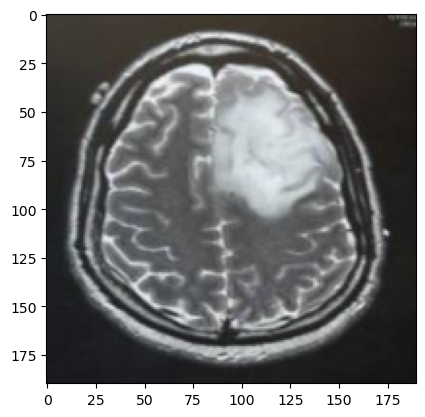

In [19]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

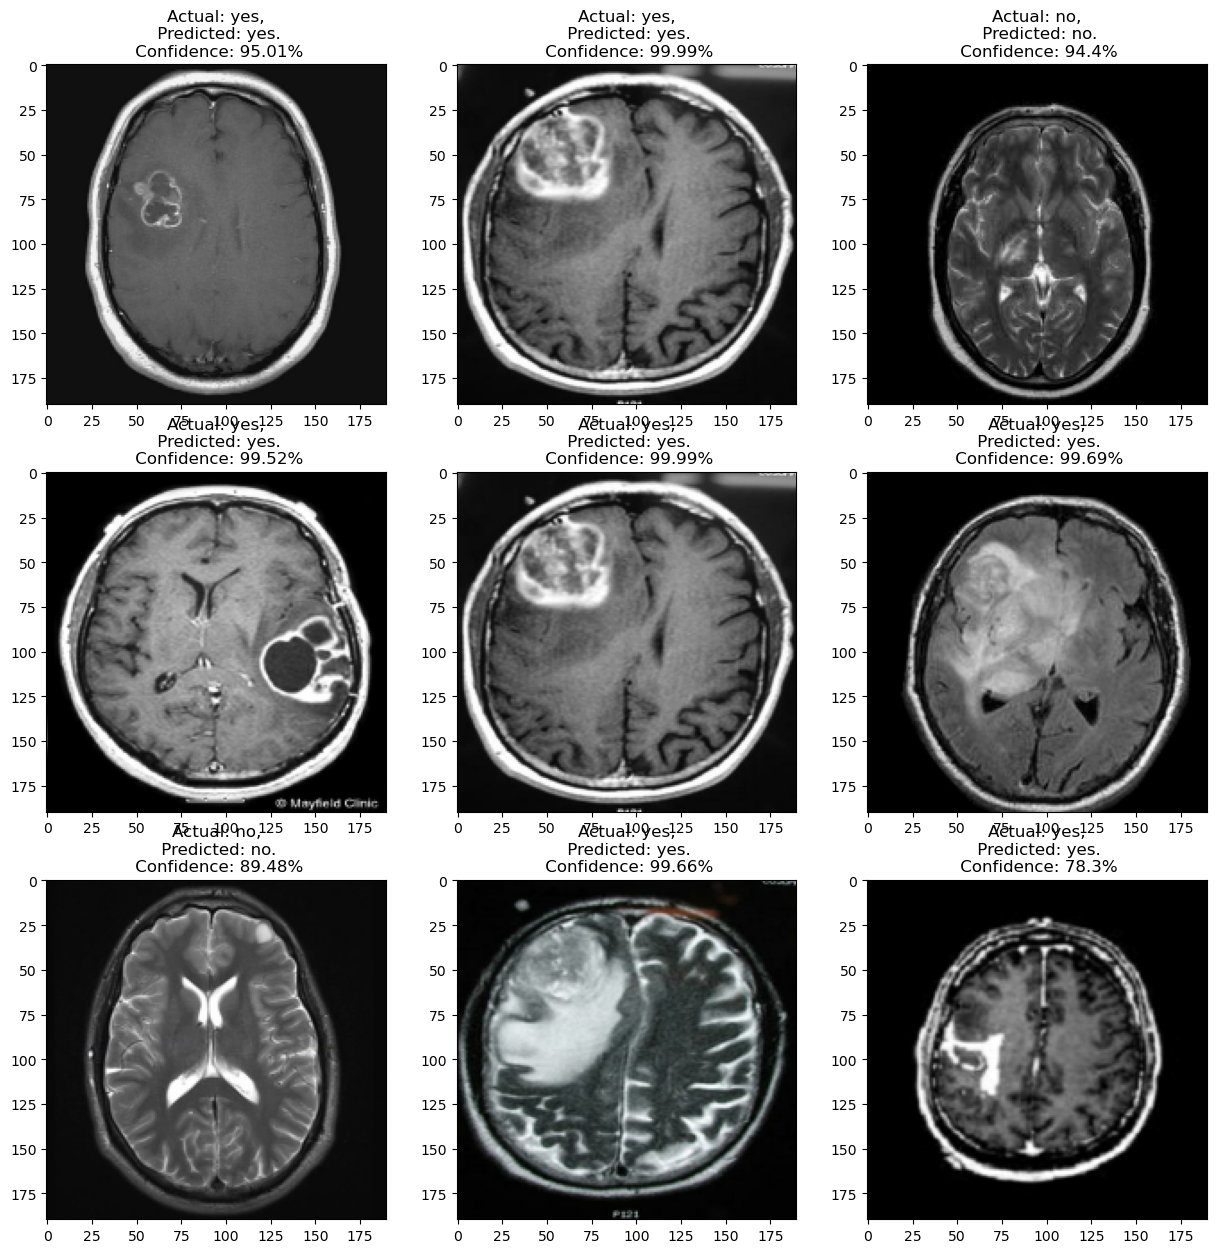

In [21]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model,images[i].numpy)
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")